# Tracking the Growth of COVID-19 Cases in US

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

For a great primer on exponential and logistic growth, watch [this video](https://www.youtube.com/watch?v=Kas0tIxDvrg).

## Important Caveats:

- The growth rate (and the doubling time) changes with time. As the exponential curve eventually turns into a logistic curve, the growth rate will shrink to zero (& the doubling time will consequently increase). **So it's not a good idea to extrapolate trends far into the future based on current growth rates or doubling times.**

- The confirmed cases reported by each country are not the number of infections in each country, only those that have tested positive.

- The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infections. For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but infections may not be rising as the same rate.

- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from termcolor import colored, cprint

import plotly.graph_objects as go
#import plotly.offline as offline
#offline.init_notebook_mode(connected=True)

## Curve Fitting Global COVID-19 Cases

In [2]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country, maxfev=100000, use_plotly=False):
#def plotCases(dataframe, column, country, maxfev=1):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    if(use_plotly is False):
        plt.figure(figsize=(10,5))
        plt.plot(x, y, 'ko', label="Original Data")
    else:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Original Data'))
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=maxfev)
        lerror = np.sqrt(np.diag(lpcov))

        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])

        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  

        if logisticr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=logistic(x, *lpopt), mode='lines', line=dict(dash='dot'), name="Logistic Curve Fit") )
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            print("\tparam: ", lpopt)
            logisticworked = True
        else:
            print("\n logistic R^2 ", logisticr2)    
    except Exception as ex:
        cprint('\nException in logstic process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=maxfev)
        eerror = np.sqrt(np.diag(epcov))

        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])

        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)

        if expr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=exponential(x, *epopt), mode='lines', line=dict(dash='dot'), name="Exponential Curve Fit"))
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            print("\tparam: ", epopt)
            exponentialworked = True
        else:
            print("\n exponential R^2 ", expr2)    
    except Exception as ex:
        cprint('\nException in exponential process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    if(use_plotly == False):
        plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
        plt.xlabel('Days', fontsize="x-large")
        plt.ylabel('Total Cases', fontsize="x-large")
        plt.legend(fontsize="x-large")
        plt.show()
    else:
        fig.update_layout(title=country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')'
                          ,  xaxis_title='Days'
                          , yaxis_title='Total Cases'
                          , width=900, height=700,  autosize=False
                          #,paper_bgcolor='black'
                         )
        fig.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]

## US COVID-19 Analysis

In [3]:
datadir = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
df = pd.read_csv( datadir + 'time_series_covid19_confirmed_US.csv')
#df = pd.read_csv( datadir + 'time_series_covid19_deaths_US.csv')

In [4]:
uscases = df

# For some reason they change column names, change them back.
uscases.rename(columns={
    'Country_Region':'Country/Region',
    'Province_State':'Province/State',
    'Long_':'Long'
}, inplace=True)


# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

# global
# Province/State,Country/Region,Lat,Long,1/22/20

# US
# UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/2020

# Province/State  Country/Region      Lat     Long  1/22/20
uscases = uscases.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key'])

usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()

mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary.head()



Number of confirmed US COVID-19 cases by state as of 4/9/20


,4/9/20
Province/State,
New York,161779
New Jersey,51027
Michigan,21504
California,19710
Massachusetts,18941


## Curve Fitting US COVID-19 Cases

                      4/9/20
Province/State              
New York              161779
New Jersey             51027
Michigan               21504
California             19710
Massachusetts          18941
Pennsylvania           18300
Louisiana              18283
Florida                16364
Illinois               15079
Texas                  11208
Georgia                10566
Connecticut             9784
Washington              9639
Indiana                 6351
Maryland                6185
Colorado                5655
Ohio                    5512
Tennessee               4634
Virginia                4042
North Carolina          3736
Missouri                3432
Arizona                 3018
Wisconsin               2886
South Carolina          2793
Alabama                 2703
Nevada                  2456
Mississippi             2260
Utah                    1856
Rhode Island            1727
Oklahoma                1686
District of Columbia    1523
Kentucky                1341
Oregon        

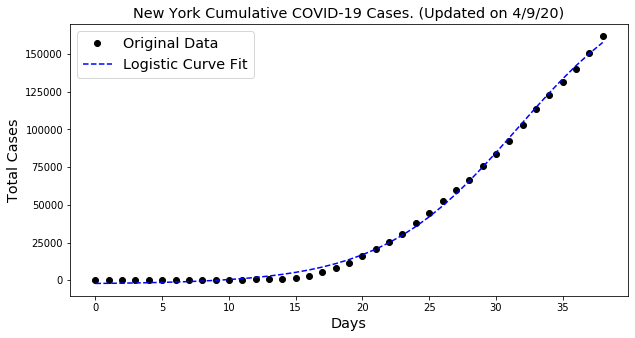



US state:  New Jersey

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 51027
	Confirmed cases on 4/2/20 	 25590
	Ratio: 1.99
	Weekly increase: 99.4 %
	Daily increase: 10.4 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.9994127263151533
	Doubling Time (during middle of growth):  5.56 (± 0.24 ) days
	param:  [ 1.49050595e+03  2.49521591e-01 -3.73711876e+02  6.25239915e+04]

 exponential R^2  0.926299316078102


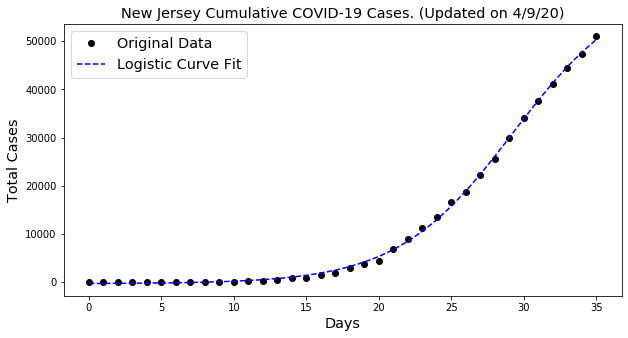



US state:  Michigan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 21504
	Confirmed cases on 4/2/20 	 10791
	Ratio: 1.99
	Weekly increase: 99.3 %
	Daily increase: 10.4 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.9996943497558438
	Doubling Time (during middle of growth):  5.81 (± 0.22 ) days
	param:  [ 2.89814977e+02  2.38808698e-01 -2.47440615e+02  2.77006886e+04]

 exponential R^2  0.9084603273431473


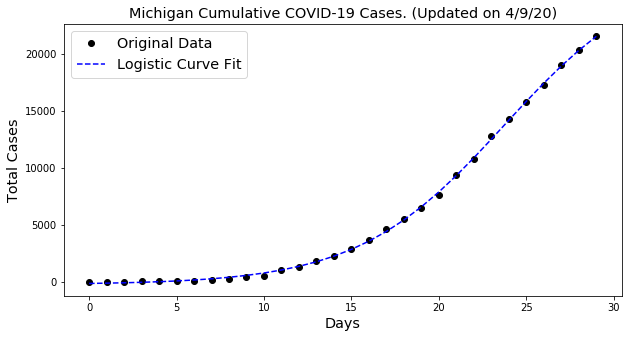



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 19710
	Confirmed cases on 4/2/20 	 10773
	Ratio: 1.83
	Weekly increase: 83.0 %
	Daily increase: 9.0 % per day
	Doubling Time (represents recent growth): 8.0 days

** Based on Logistic Fit**

	R^2: 0.9996267865693347
	Doubling Time (during middle of growth):  6.91 (± 0.16 ) days
	param:  [ 1.09456039e+06  2.00653304e-01 -5.56313575e+00  2.75472003e+04]

** Based on Exponential Fit **

	R^2: 0.9887596162448901
	Doubling Time (represents overall growth):  5.89 (± 0.31 ) days
	param:  [   3.60775901    0.11777334 -100.        ]


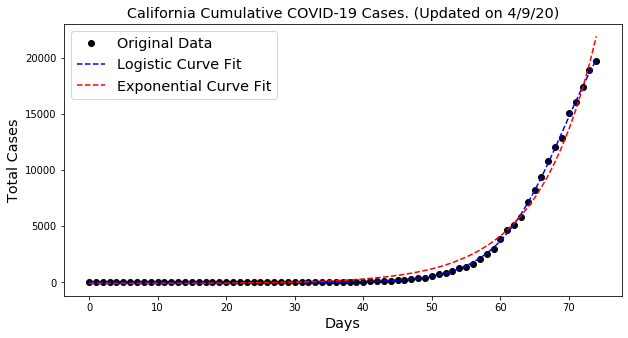



US state:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 18941
	Confirmed cases on 4/2/20 	 8966
	Ratio: 2.11
	Weekly increase: 111.3 %
	Daily increase: 11.3 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.9977480464239002
	Doubling Time (during middle of growth):  6.12 (± 0.37 ) days
	param:  [ 1.76854169e+06  2.26376313e-01 -4.54008297e+01  2.47335907e+04]

** Based on Exponential Fit **

	R^2: 0.9863573764693794
	Doubling Time (represents overall growth):  5.23 (± 0.31 ) days
	param:  [   2.47628665    0.13247821 -100.        ]


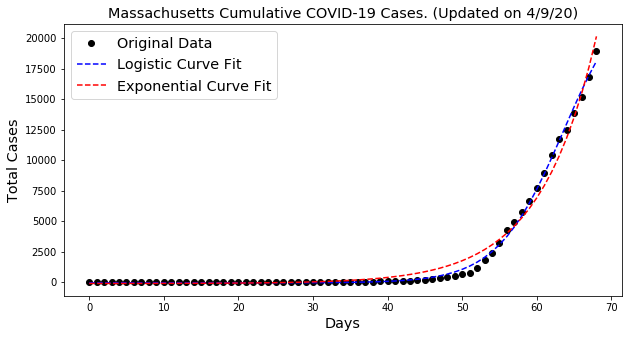



US state:  Pennsylvania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 18300
	Confirmed cases on 4/2/20 	 7268
	Ratio: 2.52
	Weekly increase: 151.8 %
	Daily increase: 14.1 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.9996097391788419
	Doubling Time (during middle of growth):  5.96 (± 0.23 ) days
	param:  [ 1.54713610e+03  2.32794353e-01 -9.31683940e+01  2.85300208e+04]

** Based on Exponential Fit **

	R^2: 0.9897121993299137
	Doubling Time (represents overall growth):  4.45 (± 0.37 ) days
	param:  [ 100.            0.15584894 -100.        ]


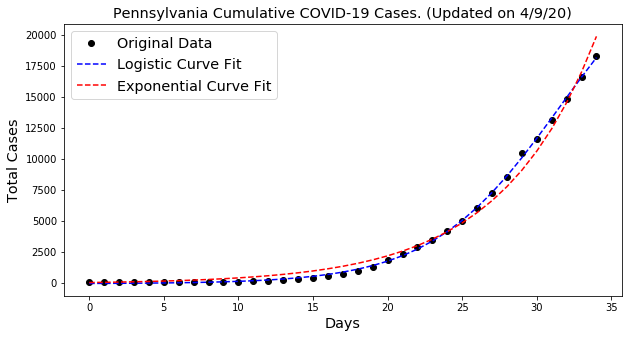



US state:  Louisiana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 18283
	Confirmed cases on 4/2/20 	 9149
	Ratio: 2.0
	Weekly increase: 99.8 %
	Daily increase: 10.4 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.9965876331641839
	Doubling Time (during middle of growth):  4.8 (± 0.55 ) days
	param:  [9.25613927e+02 2.88847746e-01 1.66069310e+02 2.21888164e+04]

 exponential R^2  0.9369883320900327


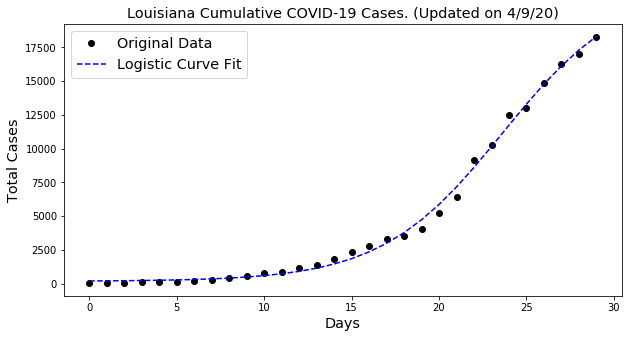



US state:  Florida

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 16364
	Confirmed cases on 4/2/20 	 9008
	Ratio: 1.82
	Weekly increase: 81.7 %
	Daily increase: 8.9 % per day
	Doubling Time (represents recent growth): 8.1 days

** Based on Logistic Fit**

	R^2: 0.9991353598454437
	Doubling Time (during middle of growth):  5.43 (± 0.27 ) days
	param:  [ 3.33598717e+03  2.55391129e-01 -2.72596384e+01  1.95415394e+04]

** Based on Exponential Fit **

	R^2: 0.9713734948697109
	Doubling Time (represents overall growth):  5.01 (± 0.66 ) days
	param:  [ 100.            0.13839183 -100.        ]


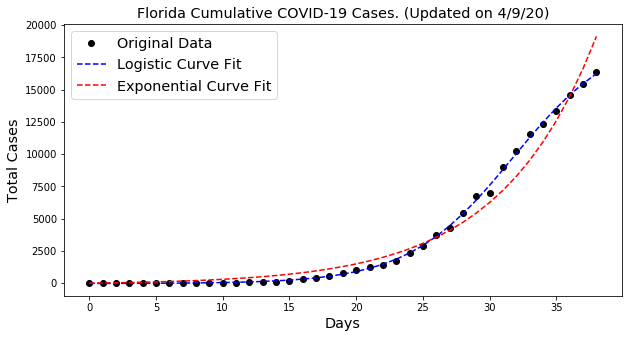



US state:  Illinois

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 15079
	Confirmed cases on 4/2/20 	 7695
	Ratio: 1.96
	Weekly increase: 96.0 %
	Daily increase: 10.1 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.9978758916458015
	Doubling Time (during middle of growth):  6.21 (± 0.34 ) days
	param:  [ 7.40942029e+06  2.23415137e-01 -2.69090951e+01  1.98261760e+04]

** Based on Exponential Fit **

	R^2: 0.9844717567997779
	Doubling Time (represents overall growth):  5.57 (± 0.33 ) days
	param:  [   1.32364207    0.12446325 -100.        ]


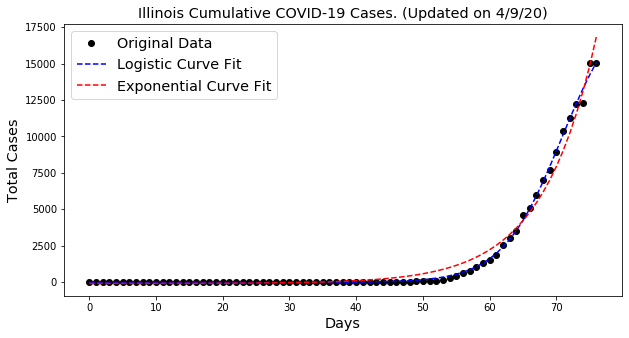



US state:  Texas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 11208
	Confirmed cases on 4/2/20 	 5069
	Ratio: 2.21
	Weekly increase: 121.1 %
	Daily increase: 12.0 % per day
	Doubling Time (represents recent growth): 6.1 days

** Based on Logistic Fit**

	R^2: 0.9988892854700766
	Doubling Time (during middle of growth):  7.48 (± 0.54 ) days
	param:  [ 5.07251378e+02  1.85402587e-01 -1.31334776e+02  1.93735216e+04]

** Based on Exponential Fit **

	R^2: 0.9908508988361114
	Doubling Time (represents overall growth):  5.07 (± 0.4 ) days
	param:  [ 100.            0.13669286 -100.        ]


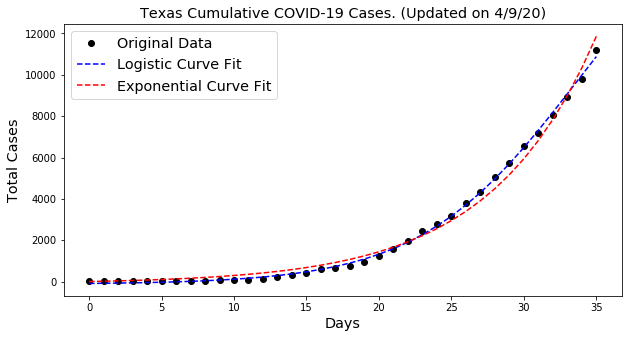



US state:  Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 10566
	Confirmed cases on 4/2/20 	 5348
	Ratio: 1.98
	Weekly increase: 97.6 %
	Daily increase: 10.2 % per day
	Doubling Time (represents recent growth): 7.1 days

** Based on Logistic Fit**

	R^2: 0.9958152861115769
	Doubling Time (during middle of growth):  7.53 (± 0.99 ) days
	param:  [ 6.66324851e+02  1.84081713e-01 -1.18496789e+02  1.82032546e+04]

** Based on Exponential Fit **

	R^2: 0.9886123891151761
	Doubling Time (represents overall growth):  5.39 (± 0.47 ) days
	param:  [  97.61152642    0.12851738 -100.        ]


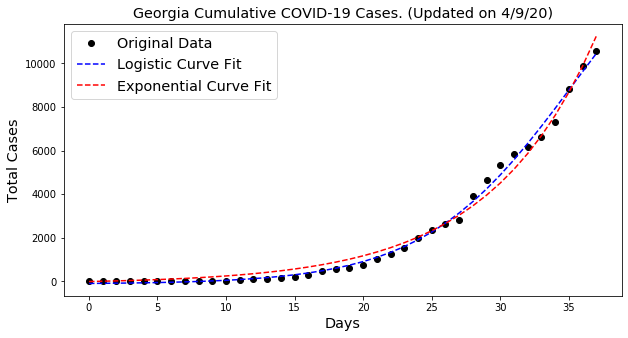



US state:  Connecticut

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 9784
	Confirmed cases on 4/2/20 	 3824
	Ratio: 2.56
	Weekly increase: 155.9 %
	Daily increase: 14.4 % per day
	Doubling Time (represents recent growth): 5.2 days

** Based on Logistic Fit**

	R^2: 0.9948045155327958
	Doubling Time (during middle of growth):  7.0 (± 1.23 ) days
	param:  [ 2.88354705e+02  1.97980643e-01 -1.60206144e+02  1.64546903e+04]

** Based on Exponential Fit **

	R^2: 0.982443196387626
	Doubling Time (represents overall growth):  4.48 (± 0.54 ) days
	param:  [100.           0.15457219 -45.94746001]


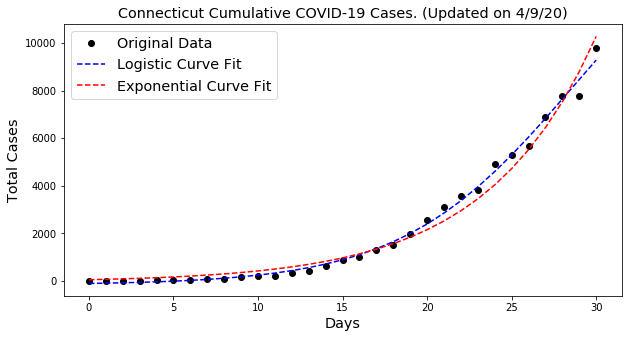



US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 9639
	Confirmed cases on 4/2/20 	 6389
	Ratio: 1.51
	Weekly increase: 50.9 %
	Daily increase: 6.1 % per day
	Doubling Time (represents recent growth): 11.8 days

** Based on Logistic Fit**

	R^2: 0.9993375667589222
	Doubling Time (during middle of growth):  8.89 (± 0.27 ) days
	param:  [ 6.64353757e+04  1.55856078e-01 -2.74403458e+01  1.29533178e+04]

** Based on Exponential Fit **

	R^2: 0.9869866586634856
	Doubling Time (represents overall growth):  7.79 (± 0.44 ) days
	param:  [ 1.04999169e+01  8.89439214e-02 -1.00000000e+02]


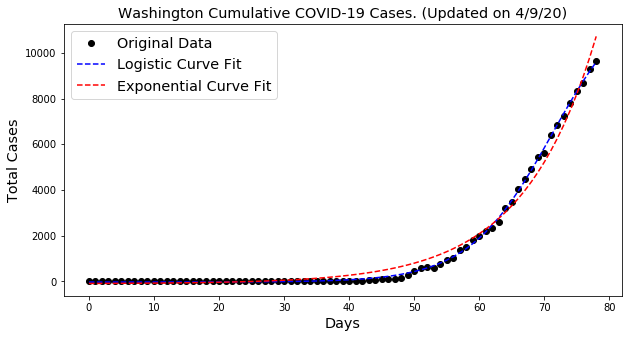



US state:  Indiana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 6351
	Confirmed cases on 4/2/20 	 3038
	Ratio: 2.09
	Weekly increase: 109.1 %
	Daily increase: 11.1 % per day
	Doubling Time (represents recent growth): 6.6 days

** Based on Logistic Fit**

	R^2: 0.9993077178690806
	Doubling Time (during middle of growth):  5.62 (± 0.28 ) days
	param:  [ 1.35715234e+03  2.46504613e-01 -4.66641830e+01  8.29554319e+03]

** Based on Exponential Fit **

	R^2: 0.9829627730637157
	Doubling Time (represents overall growth):  5.13 (± 0.59 ) days
	param:  [  71.98955511    0.13518715 -100.        ]


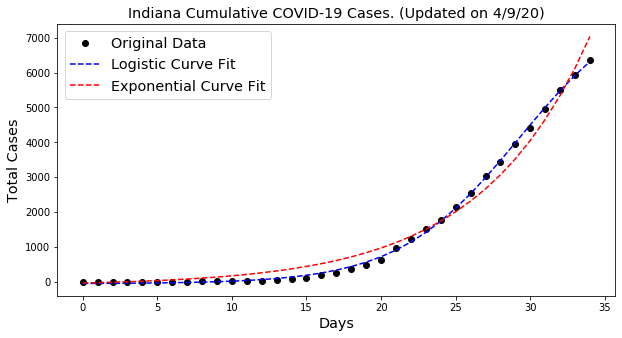



US state:  Maryland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 6185
	Confirmed cases on 4/2/20 	 2331
	Ratio: 2.65
	Weekly increase: 165.3 %
	Daily increase: 15.0 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Logistic Fit**

	R^2: 0.9974206912957193
	Doubling Time (during middle of growth):  7.66 (± 0.93 ) days
	param:  [ 8.49050341e+02  1.80896055e-01 -6.98735603e+01  1.72401518e+04]

** Based on Exponential Fit **

	R^2: 0.9959387880332866
	Doubling Time (represents overall growth):  4.74 (± 0.25 ) days
	param:  [  44.17072696    0.14634672 -100.        ]


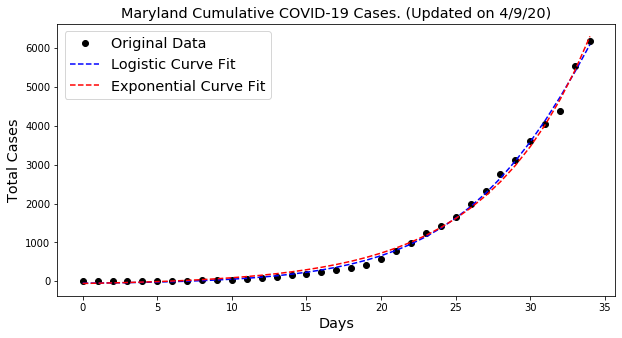



US state:  Colorado

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 5655
	Confirmed cases on 4/2/20 	 3342
	Ratio: 1.69
	Weekly increase: 69.2 %
	Daily increase: 7.8 % per day
	Doubling Time (represents recent growth): 9.2 days

** Based on Logistic Fit**

	R^2: 0.9966237337898868
	Doubling Time (during middle of growth):  6.41 (± 0.7 ) days
	param:  [ 3.52287513e+02  2.16215930e-01 -2.89078351e+01  7.19699540e+03]

** Based on Exponential Fit **

	R^2: 0.9613978518812305
	Doubling Time (represents overall growth):  5.56 (± 0.99 ) days
	param:  [100.           0.12462871   1.35681468]


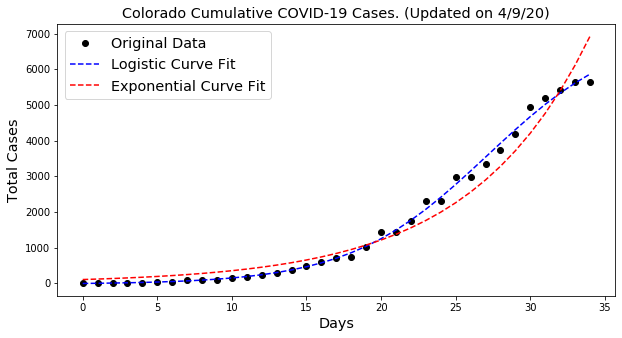



US state:  Ohio

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 5512
	Confirmed cases on 4/2/20 	 2901
	Ratio: 1.9
	Weekly increase: 90.0 %
	Daily increase: 9.6 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.9995910037965499
	Doubling Time (during middle of growth):  6.44 (± 0.28 ) days
	param:  [ 1.99390407e+02  2.15097377e-01 -8.04306820e+01  7.19253689e+03]

** Based on Exponential Fit **

	R^2: 0.9694334218053896
	Doubling Time (represents overall growth):  5.01 (± 0.85 ) days
	param:  [100.           0.13831986   3.7672    ]


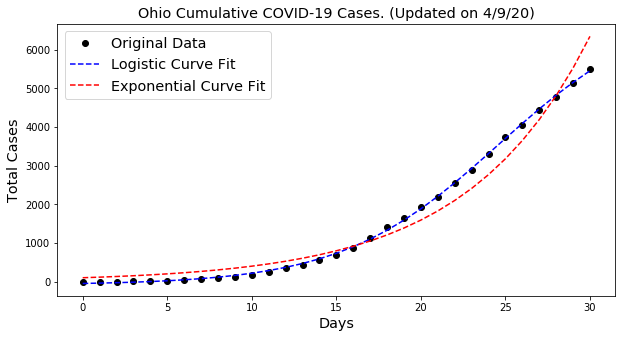



US state:  Tennessee

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 4634
	Confirmed cases on 4/2/20 	 3013
	Ratio: 1.54
	Weekly increase: 53.8 %
	Daily increase: 6.3 % per day
	Doubling Time (represents recent growth): 11.3 days

** Based on Logistic Fit**

	R^2: 0.9967839557820145
	Doubling Time (during middle of growth):  6.23 (± 0.63 ) days
	param:  [ 3.96255721e+02  2.22696400e-01 -6.15608442e+01  5.22109792e+03]

** Based on Exponential Fit **

	R^2: 0.9614130804355059
	Doubling Time (represents overall growth):  6.06 (± 1.09 ) days
	param:  [100.           0.11433216 -88.9307418 ]


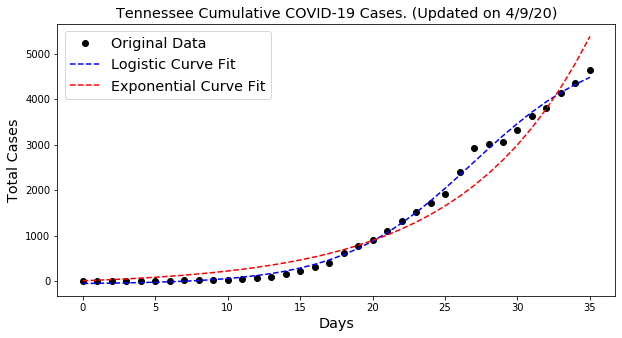



US state:  Virginia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 4042
	Confirmed cases on 4/2/20 	 1706
	Ratio: 2.37
	Weekly increase: 136.9 %
	Daily increase: 13.1 % per day
	Doubling Time (represents recent growth): 5.6 days

** Based on Logistic Fit**

	R^2: 0.9994675866799171
	Doubling Time (during middle of growth):  6.63 (± 0.34 ) days
	param:  [ 5.21364761e+02  2.09078563e-01 -1.79292951e+01  6.61179977e+03]

** Based on Exponential Fit **

	R^2: 0.993768573274023
	Doubling Time (represents overall growth):  5.23 (± 0.38 ) days
	param:  [  63.03800281    0.13248206 -100.        ]


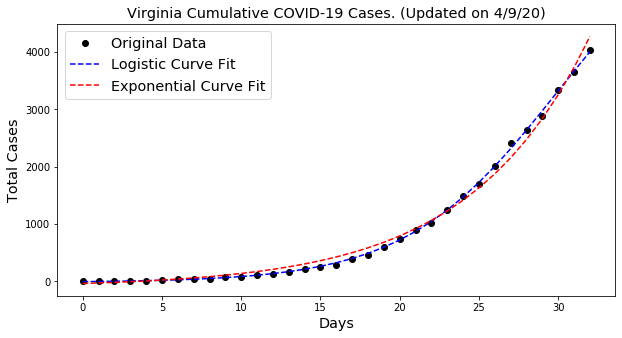



US state:  North Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 3736
	Confirmed cases on 4/2/20 	 1977
	Ratio: 1.89
	Weekly increase: 89.0 %
	Daily increase: 9.5 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.9990682319685095
	Doubling Time (during middle of growth):  7.37 (± 0.44 ) days
	param:  [ 4.87911610e+02  1.88174862e-01 -4.57018698e+01  5.46494554e+03]

** Based on Exponential Fit **

	R^2: 0.9889175764303129
	Doubling Time (represents overall growth):  6.16 (± 0.56 ) days
	param:  [  64.89134046    0.11250815 -100.        ]


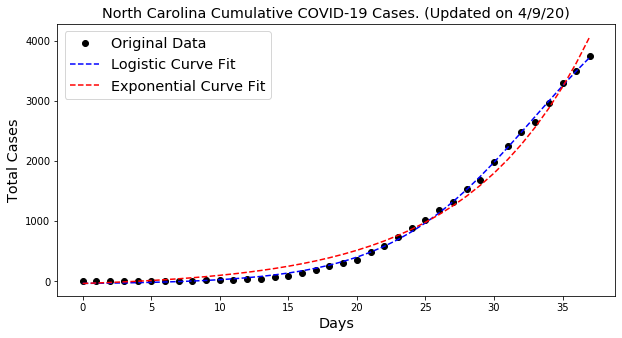



US state:  Missouri

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 3432
	Confirmed cases on 4/2/20 	 1857
	Ratio: 1.85
	Weekly increase: 84.8 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.9966092750625106
	Doubling Time (during middle of growth):  6.1 (± 0.71 ) days
	param:  [ 4.37510352e+02  2.27294670e-01 -5.10570161e+01  4.46650284e+03]

** Based on Exponential Fit **

	R^2: 0.9798487558314609
	Doubling Time (represents overall growth):  5.67 (± 0.78 ) days
	param:  [  78.1027409     0.12230487 -100.        ]


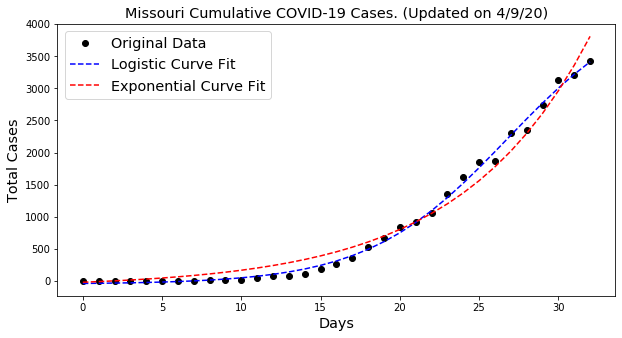



US state:  Arizona

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 3018
	Confirmed cases on 4/2/20 	 1715
	Ratio: 1.76
	Weekly increase: 76.0 %
	Daily increase: 8.4 % per day
	Doubling Time (represents recent growth): 8.6 days

** Based on Logistic Fit**

	R^2: 0.9989553308850023
	Doubling Time (during middle of growth):  5.36 (± 0.2 ) days
	param:  [ 3.55359203e+07  2.58592758e-01 -3.46574402e+00  3.65472237e+03]

** Based on Exponential Fit **

	R^2: 0.9763215978068086
	Doubling Time (represents overall growth):  5.8 (± 0.44 ) days
	param:  [  0.51957841   0.11955418 -49.72410509]


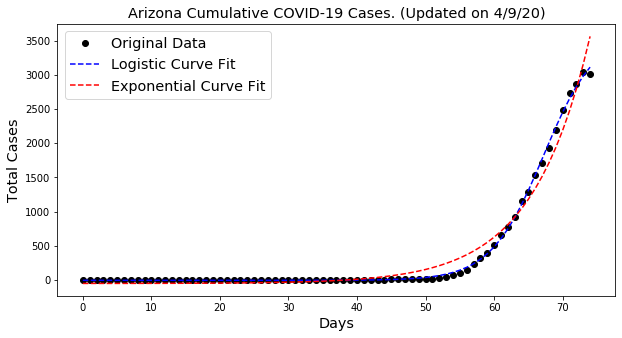



US state:  Wisconsin

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 2886
	Confirmed cases on 4/2/20 	 1748
	Ratio: 1.65
	Weekly increase: 65.1 %
	Daily increase: 7.4 % per day
	Doubling Time (represents recent growth): 9.7 days

** Based on Logistic Fit**

	R^2: 0.9984488994154241
	Doubling Time (during middle of growth):  7.86 (± 0.76 ) days
	param:  [ 6.21356957e+01  1.76310335e-01 -9.84254212e+01  3.78750147e+03]

** Based on Exponential Fit **

	R^2: 0.9605033534256405
	Doubling Time (represents overall growth):  5.93 (± 1.26 ) days
	param:  [100.           0.11685633   9.73476286]


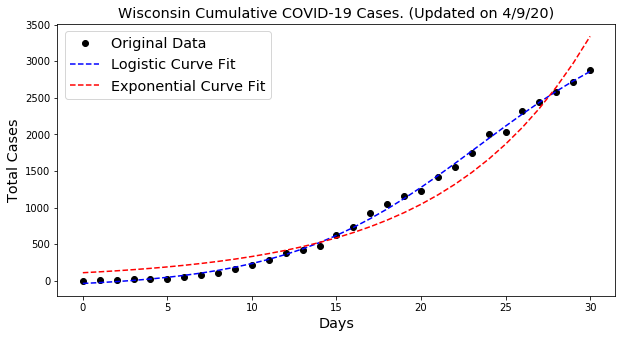



US state:  South Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 2793
	Confirmed cases on 4/2/20 	 1554
	Ratio: 1.8
	Weekly increase: 79.7 %
	Daily increase: 8.7 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.9979987148016694
	Doubling Time (during middle of growth):  6.11 (± 0.53 ) days
	param:  [ 4.65244180e+02  2.26798957e-01 -1.15347390e+01  3.40214224e+03]

** Based on Exponential Fit **

	R^2: 0.9821671508470499
	Doubling Time (represents overall growth):  6.2 (± 0.81 ) days
	param:  [  77.6245272     0.11180248 -100.        ]


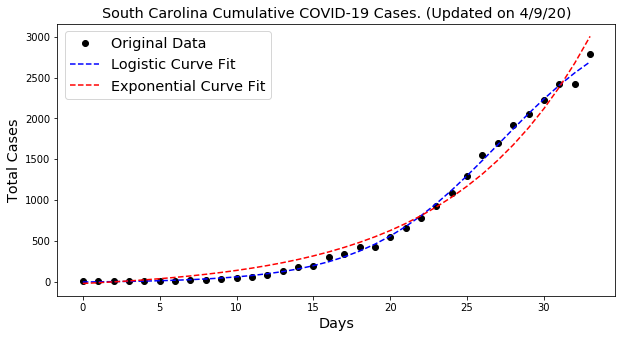



US state:  Alabama

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 2703
	Confirmed cases on 4/2/20 	 1233
	Ratio: 2.19
	Weekly increase: 119.2 %
	Daily increase: 11.9 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.9966142097948728
	Doubling Time (during middle of growth):  9.86 (± 2.24 ) days
	param:  [ 5.83982603e+01  1.40557709e-01 -1.51262186e+02  6.25623807e+03]

** Based on Exponential Fit **

	R^2: 0.9865126132656444
	Doubling Time (represents overall growth):  5.56 (± 0.73 ) days
	param:  [100.           0.12459143 -59.26027535]


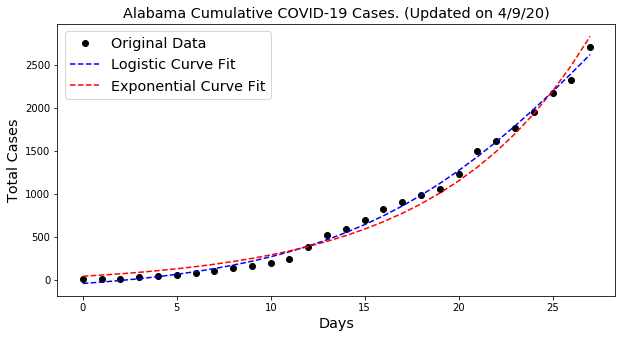



US state:  Nevada

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 2456
	Confirmed cases on 4/2/20 	 1463
	Ratio: 1.68
	Weekly increase: 67.9 %
	Daily increase: 7.7 % per day
	Doubling Time (represents recent growth): 9.4 days

** Based on Logistic Fit**

	R^2: 0.9975149051394713
	Doubling Time (during middle of growth):  6.06 (± 0.54 ) days
	param:  [ 6.02049157e+02  2.28642568e-01 -1.49427324e+01  2.84446081e+03]

** Based on Exponential Fit **

	R^2: 0.9785350291159923
	Doubling Time (represents overall growth):  6.58 (± 0.92 ) days
	param:  [  69.81221882    0.10531735 -100.        ]


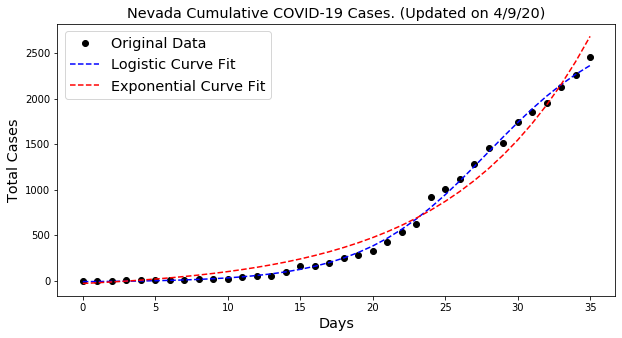



US state:  Mississippi

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 2260
	Confirmed cases on 4/2/20 	 1177
	Ratio: 1.92
	Weekly increase: 92.0 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.99817058235196
	Doubling Time (during middle of growth):  8.86 (± 1.19 ) days
	param:  [ 4.85225672e+01  1.56502735e-01 -1.20655714e+02  3.60246465e+03]

** Based on Exponential Fit **

	R^2: 0.9804561458936573
	Doubling Time (represents overall growth):  6.02 (± 0.97 ) days
	param:  [100.           0.11518433 -65.79588417]


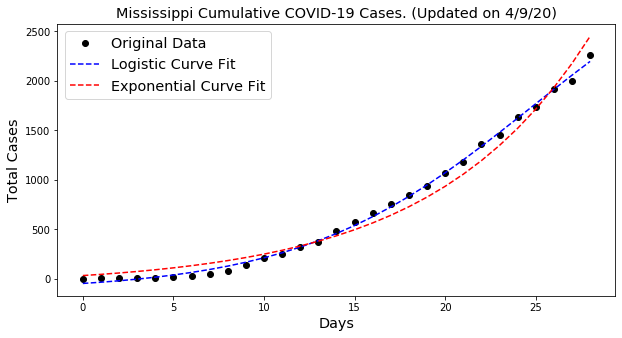



US state:  Utah

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1856
	Confirmed cases on 4/2/20 	 1092
	Ratio: 1.7
	Weekly increase: 70.0 %
	Daily increase: 7.9 % per day
	Doubling Time (represents recent growth): 9.1 days

** Based on Logistic Fit**

	R^2: 0.9967367034804109
	Doubling Time (during middle of growth):  6.45 (± 0.72 ) days
	param:  [ 2.81385637e+02  2.15083515e-01 -2.11526540e+01  2.37220245e+03]

** Based on Exponential Fit **

	R^2: 0.9773026635142743
	Doubling Time (represents overall growth):  6.86 (± 1.08 ) days
	param:  [  80.27722874    0.1010573  -100.        ]


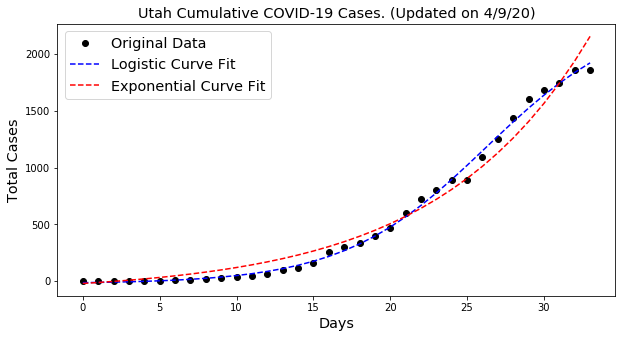



US state:  Rhode Island

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1727
	Confirmed cases on 4/2/20 	 645
	Ratio: 2.68
	Weekly increase: 167.8 %
	Daily increase: 15.1 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Logistic Fit**

	R^2: 0.9975393316821332
	Doubling Time (during middle of growth):  8.47 (± 0.96 ) days
	param:  [ 2.83104105e+03  1.63718248e-01 -1.34537767e+01  9.79622773e+03]

** Based on Exponential Fit **

	R^2: 0.9973070549344528
	Doubling Time (represents overall growth):  4.69 (± 0.18 ) days
	param:  [  5.44216213   0.14771572 -21.2467616 ]


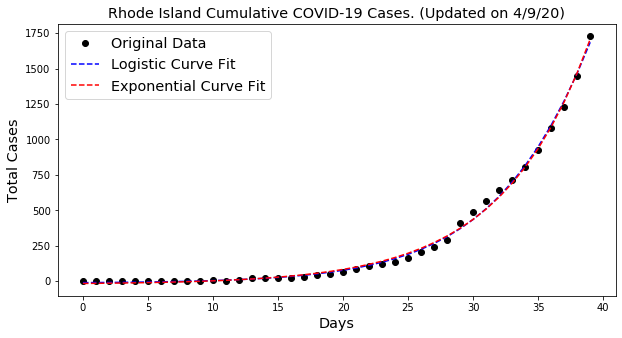



US state:  Oklahoma

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1686
	Confirmed cases on 4/2/20 	 881
	Ratio: 1.91
	Weekly increase: 91.4 %
	Daily increase: 9.7 % per day
	Doubling Time (represents recent growth): 7.5 days

** Based on Logistic Fit**

	R^2: 0.9982323635727597
	Doubling Time (during middle of growth):  5.43 (± 0.42 ) days
	param:  [ 1.02299340e+03  2.55068159e-01 -6.85369577e+00  2.02692883e+03]

** Based on Exponential Fit **

	R^2: 0.9823700709278075
	Doubling Time (represents overall growth):  6.08 (± 0.77 ) days
	param:  [  45.11933004    0.11391713 -100.        ]


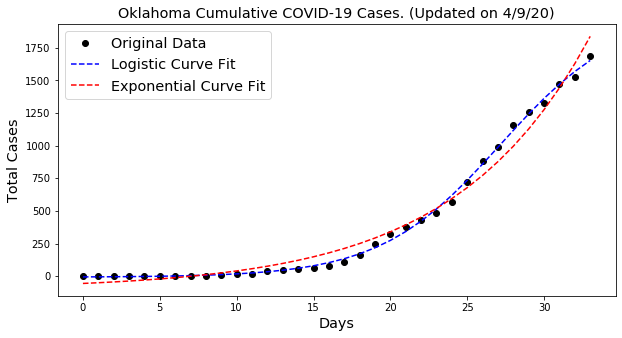



US state:  District of Columbia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1523
	Confirmed cases on 4/2/20 	 653
	Ratio: 2.33
	Weekly increase: 133.2 %
	Daily increase: 12.9 % per day
	Doubling Time (represents recent growth): 5.7 days

** Based on Logistic Fit**

	R^2: 0.9985229649450218
	Doubling Time (during middle of growth):  8.18 (± 1.21 ) days
	param:  [ 7.31471610e+01  1.69477582e-01 -2.80159102e+01  3.49854854e+03]

** Based on Exponential Fit **

	R^2: 0.9969823513480449
	Doubling Time (represents overall growth):  5.89 (± 0.43 ) days
	param:  [100.           0.1176367  -92.65945234]


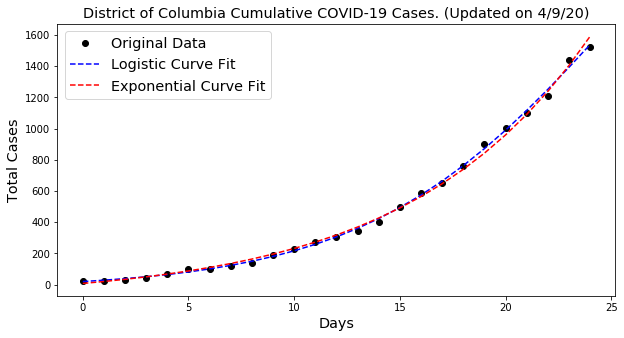



US state:  Kentucky

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1341
	Confirmed cases on 4/2/20 	 770
	Ratio: 1.74
	Weekly increase: 74.2 %
	Daily increase: 8.2 % per day
	Doubling Time (represents recent growth): 8.7 days

** Based on Logistic Fit**

	R^2: 0.9946384500760739
	Doubling Time (during middle of growth):  6.85 (± 0.99 ) days
	param:  [ 2.95375184e+02  2.02369752e-01 -1.55909641e+01  1.64761458e+03]

** Based on Exponential Fit **

	R^2: 0.9843667003864808
	Doubling Time (represents overall growth):  7.2 (± 0.92 ) days
	param:  [ 5.63518525e+01  9.62171997e-02 -1.00000000e+02]


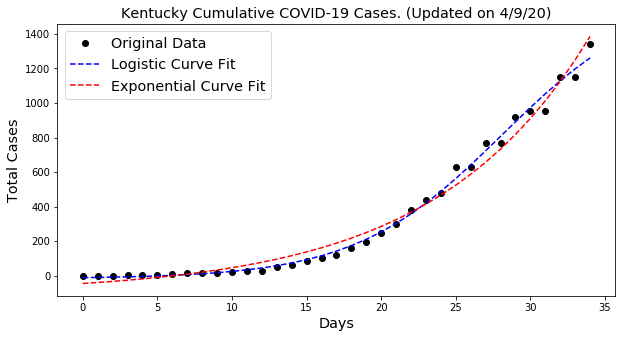



US state:  Oregon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1321
	Confirmed cases on 4/2/20 	 826
	Ratio: 1.6
	Weekly increase: 59.9 %
	Daily increase: 6.9 % per day
	Doubling Time (represents recent growth): 10.3 days

** Based on Logistic Fit**

	R^2: 0.9974346529954522
	Doubling Time (during middle of growth):  6.85 (± 0.58 ) days
	param:  [ 6.68921529e+02  2.02460671e-01 -4.34310985e+00  1.50992947e+03]

** Based on Exponential Fit **

	R^2: 0.9820476469261972
	Doubling Time (represents overall growth):  8.16 (± 1.0 ) days
	param:  [ 5.03461652e+01  8.49150874e-02 -1.00000000e+02]


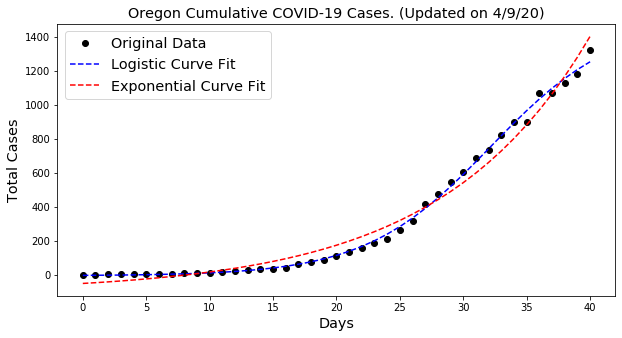



US state:  Iowa

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1270
	Confirmed cases on 4/2/20 	 614
	Ratio: 2.07
	Weekly increase: 106.8 %
	Daily increase: 10.9 % per day
	Doubling Time (represents recent growth): 6.7 days

** Based on Logistic Fit**

	R^2: 0.9986734876806705
	Doubling Time (during middle of growth):  7.06 (± 0.59 ) days
	param:  [ 2.24595405e+02  1.96411469e-01 -9.92357167e+00  1.87327363e+03]

** Based on Exponential Fit **

	R^2: 0.9928003392648631
	Doubling Time (represents overall growth):  6.55 (± 0.59 ) days
	param:  [ 52.75295698   0.10589765 -88.44802534]


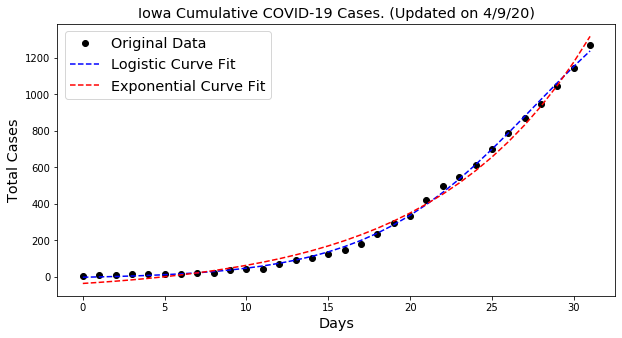



US state:  Minnesota

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1240
	Confirmed cases on 4/2/20 	 742
	Ratio: 1.67
	Weekly increase: 67.1 %
	Daily increase: 7.6 % per day
	Doubling Time (represents recent growth): 9.4 days

** Based on Logistic Fit**

	R^2: 0.9983312871849808
	Doubling Time (during middle of growth):  8.98 (± 0.87 ) days
	param:  [ 8.19066512e+01  1.54310839e-01 -4.16140103e+01  1.74201834e+03]

** Based on Exponential Fit **

	R^2: 0.9897755656047845
	Doubling Time (represents overall growth):  8.24 (± 0.93 ) days
	param:  [ 8.10403783e+01  8.40760317e-02 -1.00000000e+02]


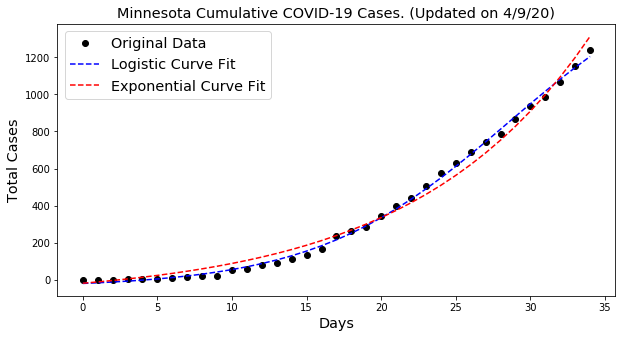



US state:  Idaho

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1232
	Confirmed cases on 4/2/20 	 776
	Ratio: 1.59
	Weekly increase: 58.8 %
	Daily increase: 6.8 % per day
	Doubling Time (represents recent growth): 10.5 days

** Based on Logistic Fit**

	R^2: 0.9971434414954586
	Doubling Time (during middle of growth):  3.5 (± 0.35 ) days
	param:  [2.02790168e+03 3.96134517e-01 1.72405703e+01 1.29518762e+03]

** Based on Exponential Fit **

	R^2: 0.9512359961562129
	Doubling Time (represents overall growth):  6.27 (± 1.75 ) days
	param:  [  79.02546247    0.1106089  -100.        ]


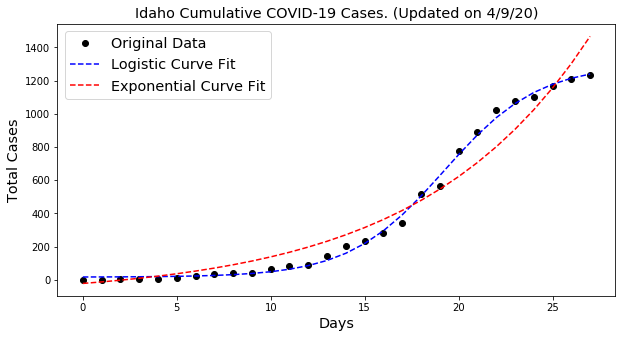



US state:  Delaware

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1209
	Confirmed cases on 4/2/20 	 393
	Ratio: 3.08
	Weekly increase: 207.6 %
	Daily increase: 17.4 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Logistic Fit**

	R^2: 0.9976788394773384
	Doubling Time (during middle of growth):  8.97 (± 1.49 ) days
	param:  [ 1.56553757e+03  1.54629412e-01 -1.89750777e+01  2.34911709e+04]

** Based on Exponential Fit **

	R^2: 0.9976623247048396
	Doubling Time (represents overall growth):  4.64 (± 0.21 ) days
	param:  [ 16.68711479   0.14928275 -22.35495031]


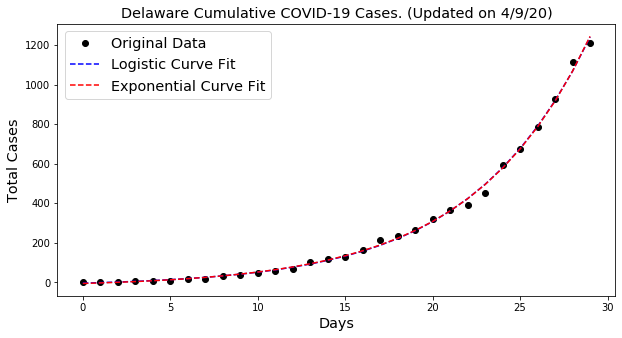



US state:  Arkansas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1119
	Confirmed cases on 4/2/20 	 643
	Ratio: 1.74
	Weekly increase: 74.0 %
	Daily increase: 8.2 % per day
	Doubling Time (represents recent growth): 8.8 days

** Based on Logistic Fit**

	R^2: 0.9959840094873285
	Doubling Time (during middle of growth):  14.06 (± 5.54 ) days
	param:  [ 1.64973374e+01  9.85728483e-02 -1.90935461e+02  2.56034021e+03]

** Based on Exponential Fit **

	R^2: 0.978228512600392
	Doubling Time (represents overall growth):  7.4 (± 1.51 ) days
	param:  [ 1.00000000e+02  9.36810813e-02 -6.56760004e+01]


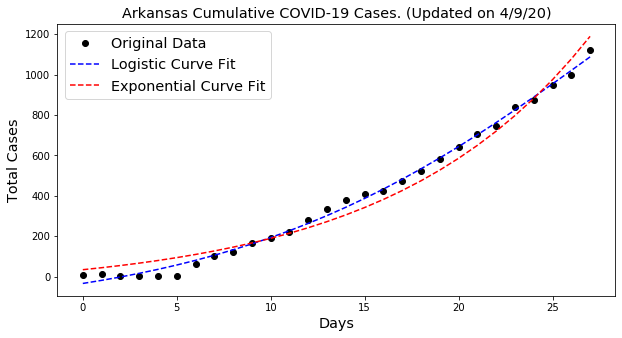



US state:  Kansas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1116
	Confirmed cases on 4/2/20 	 553
	Ratio: 2.02
	Weekly increase: 101.8 %
	Daily increase: 10.6 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.9983217474163368
	Doubling Time (during middle of growth):  7.24 (± 0.67 ) days
	param:  [ 2.41836101e+02  1.91439850e-01 -1.73272384e+01  1.68857293e+03]

** Based on Exponential Fit **

	R^2: 0.9925589652169635
	Doubling Time (represents overall growth):  6.59 (± 0.58 ) days
	param:  [ 43.25138292   0.10519352 -82.87939335]


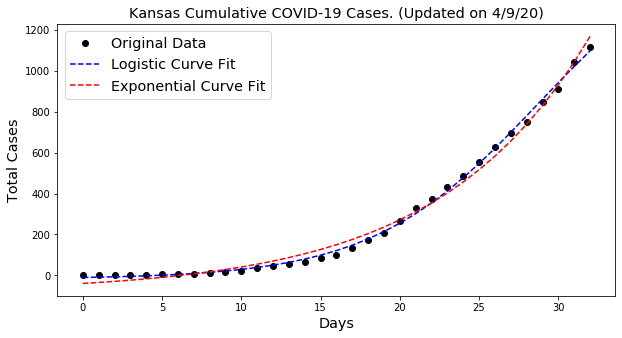



US state:  New Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 865
	Confirmed cases on 4/2/20 	 388
	Ratio: 2.23
	Weekly increase: 122.9 %
	Daily increase: 12.1 % per day
	Doubling Time (represents recent growth): 6.1 days

** Based on Logistic Fit**

	R^2: 0.9915866332887152
	Doubling Time (during middle of growth):  5.58 (± 1.1 ) days
	param:  [4.51867858e+02 2.48276230e-01 1.40844084e+01 1.24611551e+03]

** Based on Exponential Fit **

	R^2: 0.9809422280291653
	Doubling Time (represents overall growth):  6.06 (± 0.91 ) days
	param:  [ 38.31966298   0.11446067 -58.83560348]


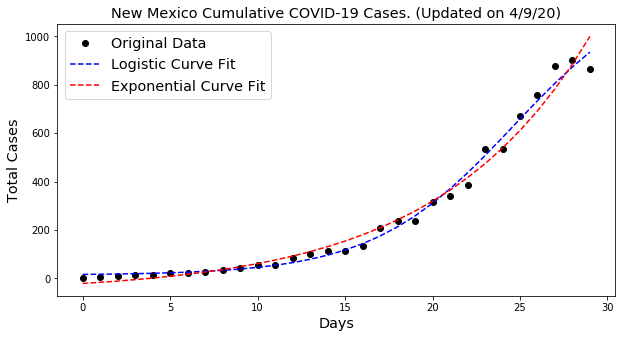



US state:  New Hampshire

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 819
	Confirmed cases on 4/2/20 	 479
	Ratio: 1.71
	Weekly increase: 71.0 %
	Daily increase: 8.0 % per day
	Doubling Time (represents recent growth): 9.0 days

** Based on Logistic Fit**

	R^2: 0.9962046700055828
	Doubling Time (during middle of growth):  6.24 (± 0.67 ) days
	param:  [1.34378790e+03 2.22167065e-01 1.72305676e+00 1.04878091e+03]

** Based on Exponential Fit **

	R^2: 0.9838647465606662
	Doubling Time (represents overall growth):  6.6 (± 0.72 ) days
	param:  [ 17.29140961   0.10497869 -43.67376529]


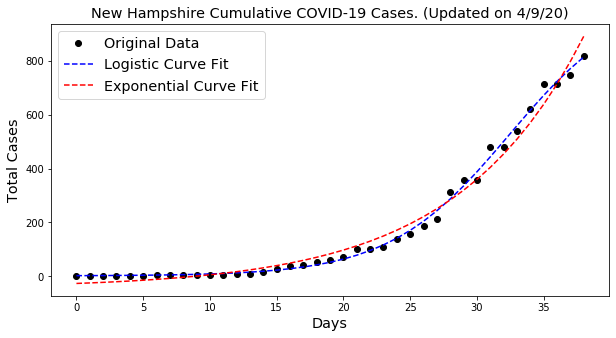



US state:  Puerto Rico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 683
	Confirmed cases on 4/2/20 	 316
	Ratio: 2.16
	Weekly increase: 116.1 %
	Daily increase: 11.6 % per day
	Doubling Time (represents recent growth): 6.3 days

** Based on Logistic Fit**

	R^2: 0.9952191806820126
	Doubling Time (during middle of growth):  5.37 (± 0.93 ) days
	param:  [ 1.41219291e+02  2.58168485e-01 -5.65380841e+00  8.62237842e+02]

** Based on Exponential Fit **

	R^2: 0.9852529937843337
	Doubling Time (represents overall growth):  6.53 (± 1.14 ) days
	param:  [ 63.36036586   0.1061921  -90.46594359]


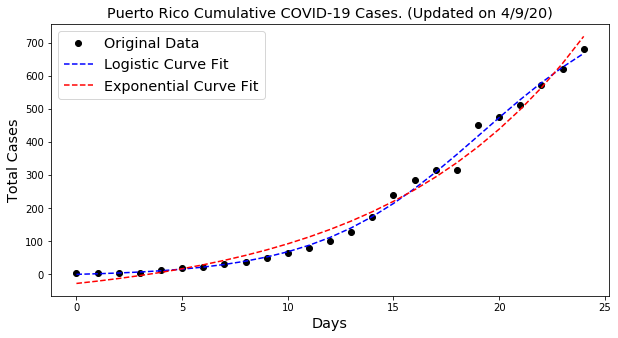



US state:  Vermont

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 628
	Confirmed cases on 4/2/20 	 338
	Ratio: 1.86
	Weekly increase: 85.8 %
	Daily increase: 9.3 % per day
	Doubling Time (represents recent growth): 7.8 days

** Based on Logistic Fit**

	R^2: 0.9966958024743714
	Doubling Time (during middle of growth):  7.45 (± 0.95 ) days
	param:  [ 1.33310010e+02  1.86183557e-01 -1.50343154e+01  8.61706752e+02]

** Based on Exponential Fit **

	R^2: 0.9875794676600541
	Doubling Time (represents overall growth):  8.39 (± 1.12 ) days
	param:  [ 5.48793766e+01  8.26417452e-02 -8.76226516e+01]


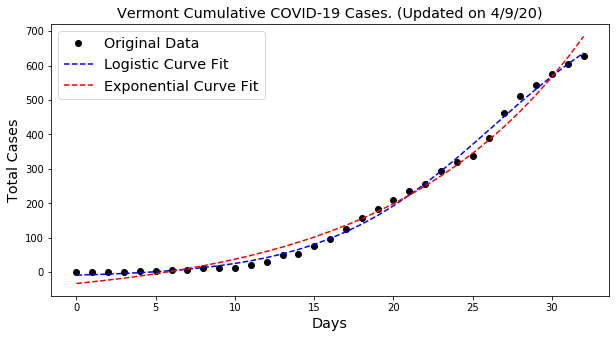



US state:  Nebraska

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 568
	Confirmed cases on 4/2/20 	 246
	Ratio: 2.31
	Weekly increase: 130.9 %
	Daily increase: 12.7 % per day
	Doubling Time (represents recent growth): 5.8 days

** Based on Logistic Fit**

	R^2: 0.9981593814052034
	Doubling Time (during middle of growth):  7.24 (± 0.69 ) days
	param:  [6.77174213e+02 1.91366601e-01 5.14769653e+00 1.13831053e+03]

** Based on Exponential Fit **

	R^2: 0.9956352706312429
	Doubling Time (represents overall growth):  5.33 (± 0.3 ) days
	param:  [ 7.1937508   0.13016832 -9.85852549]


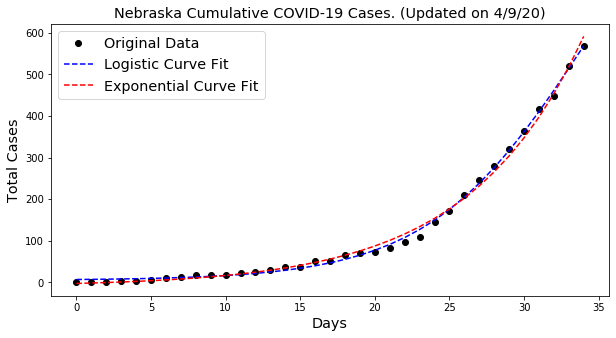



US state:  Maine

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 560
	Confirmed cases on 4/2/20 	 376
	Ratio: 1.49
	Weekly increase: 48.9 %
	Daily increase: 5.9 % per day
	Doubling Time (represents recent growth): 12.2 days

** Based on Logistic Fit**

	R^2: 0.9965763696762593
	Doubling Time (during middle of growth):  7.44 (± 1.1 ) days
	param:  [ 4.13182401e+01  1.86286269e-01 -1.55756430e+01  6.95796747e+02]

** Based on Exponential Fit **

	R^2: 0.9824021357201673
	Doubling Time (represents overall growth):  9.74 (± 2.11 ) days
	param:  [ 9.85991702e+01  7.11908588e-02 -1.00000000e+02]


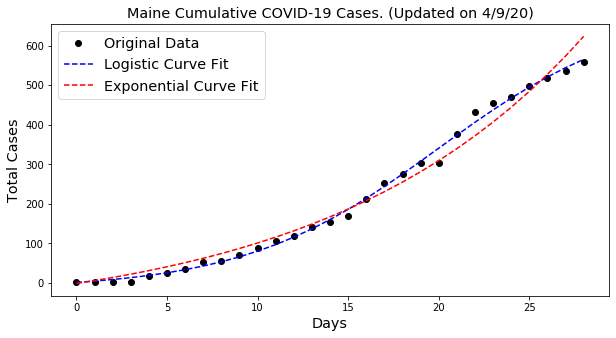



US state:  West Virginia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 514
	Confirmed cases on 4/2/20 	 216
	Ratio: 2.38
	Weekly increase: 138.0 %
	Daily increase: 13.2 % per day
	Doubling Time (represents recent growth): 5.6 days

** Based on Logistic Fit**

	R^2: 0.9969096045985095
	Doubling Time (during middle of growth):  9.62 (± 2.97 ) days
	param:  [ 5.44190029e+01  1.44076004e-01 -4.07579463e+01  1.79920161e+03]

** Based on Exponential Fit **

	R^2: 0.99651160672955
	Doubling Time (represents overall growth):  6.4 (± 0.59 ) days
	param:  [ 54.70507111   0.10832749 -66.68100516]


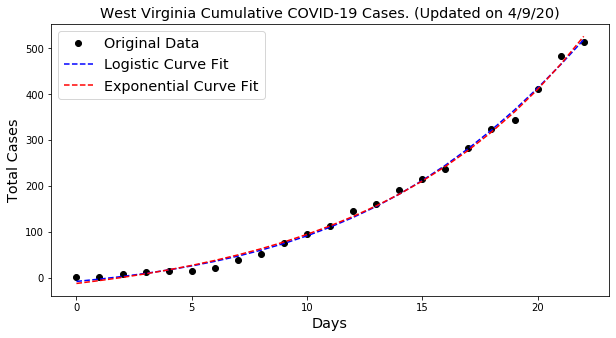



US state:  South Dakota

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 447
	Confirmed cases on 4/2/20 	 165
	Ratio: 2.71
	Weekly increase: 170.9 %
	Daily increase: 15.3 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Logistic Fit**

	R^2: 0.9983563967948743
	Doubling Time (during middle of growth):  8.36 (± 1.08 ) days
	param:  [ 7.04258618e+02  1.65824022e-01 -1.15011268e+00  3.01051732e+03]

** Based on Exponential Fit **

	R^2: 0.9982125721232993
	Doubling Time (represents overall growth):  4.61 (± 0.18 ) days
	param:  [ 5.79295067  0.15037036 -4.29580747]


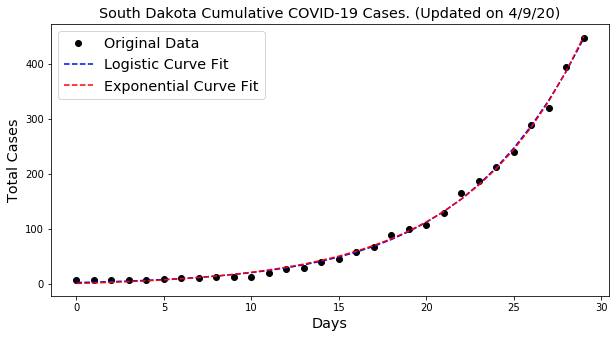



US state:  Hawaii

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 442
	Confirmed cases on 4/2/20 	 256
	Ratio: 1.73
	Weekly increase: 72.7 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

** Based on Logistic Fit**

	R^2: 0.9954259718549123
	Doubling Time (during middle of growth):  6.43 (± 0.84 ) days
	param:  [ 2.73152382e+02  2.15759778e-01 -1.70672333e+00  5.44879225e+02]

** Based on Exponential Fit **

	R^2: 0.9809257189955787
	Doubling Time (represents overall growth):  8.4 (± 1.35 ) days
	param:  [ 35.73022088   0.08256121 -57.95322595]


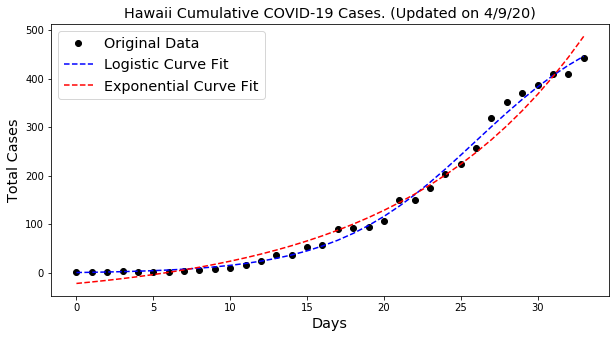



US state:  Montana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 354
	Confirmed cases on 4/2/20 	 241
	Ratio: 1.47
	Weekly increase: 46.9 %
	Daily increase: 5.6 % per day
	Doubling Time (represents recent growth): 12.6 days

** Based on Logistic Fit**

	R^2: 0.9972852440590527
	Doubling Time (during middle of growth):  6.04 (± 0.7 ) days
	param:  [ 6.14765275e+01  2.29360299e-01 -8.36540620e+00  3.84922297e+02]

** Based on Exponential Fit **

	R^2: 0.980146453418082
	Doubling Time (represents overall growth):  10.85 (± 2.85 ) days
	param:  [ 8.59090328e+01  6.39132201e-02 -1.00000000e+02]


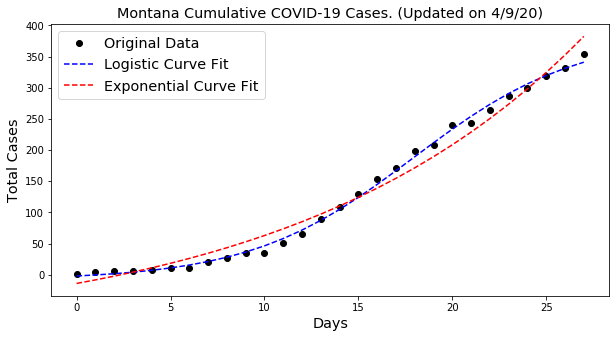



US state:  North Dakota

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 269
	Confirmed cases on 4/2/20 	 159
	Ratio: 1.69
	Weekly increase: 69.2 %
	Daily increase: 7.8 % per day
	Doubling Time (represents recent growth): 9.2 days

** Based on Logistic Fit**

	R^2: 0.9975068236774225
	Doubling Time (during middle of growth):  7.46 (± 0.97 ) days
	param:  [ 6.02165513e+01  1.85755145e-01 -7.51472826e+00  3.56913090e+02]

** Based on Exponential Fit **

	R^2: 0.9904824400025799
	Doubling Time (represents overall growth):  9.54 (± 1.46 ) days
	param:  [ 44.43991509   0.07268661 -56.73311163]


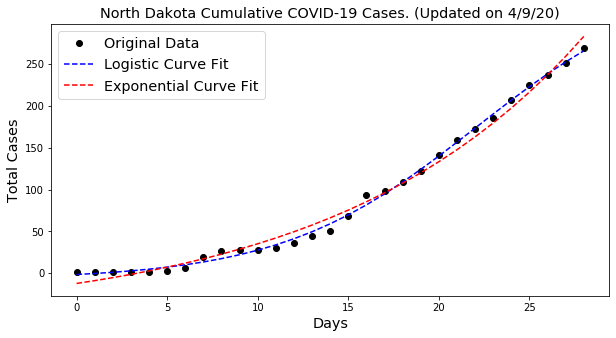



US state:  Alaska

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 235
	Confirmed cases on 4/2/20 	 143
	Ratio: 1.64
	Weekly increase: 64.3 %
	Daily increase: 7.4 % per day
	Doubling Time (represents recent growth): 9.8 days

** Based on Logistic Fit**

	R^2: 0.9959165527258435
	Doubling Time (during middle of growth):  7.0 (± 1.13 ) days
	param:  [ 4.53326187e+01  1.97936371e-01 -1.04802695e+01  2.82439640e+02]

** Based on Exponential Fit **

	R^2: 0.9861371746038432
	Doubling Time (represents overall growth):  11.59 (± 2.66 ) days
	param:  [ 6.54810181e+01  5.98285239e-02 -8.05787698e+01]


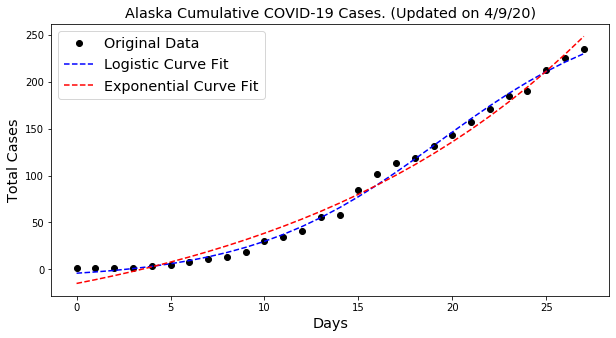



US state:  Wyoming

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 230
	Confirmed cases on 4/2/20 	 150
	Ratio: 1.53
	Weekly increase: 53.3 %
	Daily increase: 6.3 % per day
	Doubling Time (represents recent growth): 11.4 days

** Based on Logistic Fit**

	R^2: 0.9964617260685501
	Doubling Time (during middle of growth):  5.97 (± 0.76 ) days
	param:  [1.09593147e+02 2.32314550e-01 8.41206748e-01 2.71924961e+02]

** Based on Exponential Fit **

	R^2: 0.9812746908093207
	Doubling Time (represents overall growth):  10.27 (± 2.36 ) days
	param:  [ 47.20150094   0.0675235  -58.40060378]


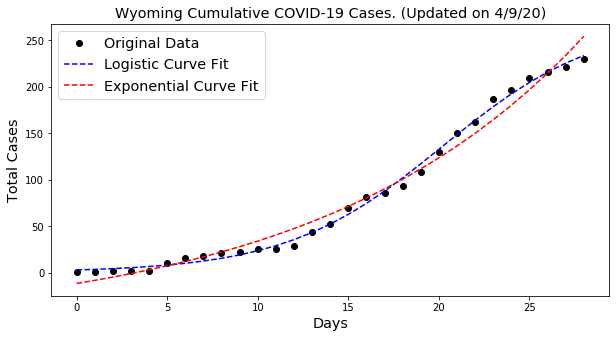



US state:  Guam

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 128
	Confirmed cases on 4/2/20 	 82
	Ratio: 1.56
	Weekly increase: 56.1 %
	Daily increase: 6.6 % per day
	Doubling Time (represents recent growth): 10.9 days

** Based on Logistic Fit**

	R^2: 0.9927303654803741
	Doubling Time (during middle of growth):  17.78 (± 17.88 ) days
	param:  [ 7.01541466e+00  7.79774400e-02 -4.45654357e+01  3.20503196e+02]

** Based on Exponential Fit **

	R^2: 0.992426095539993
	Doubling Time (represents overall growth):  19.72 (± 6.49 ) days
	param:  [ 1.00000000e+02  3.51543867e-02 -9.97450990e+01]


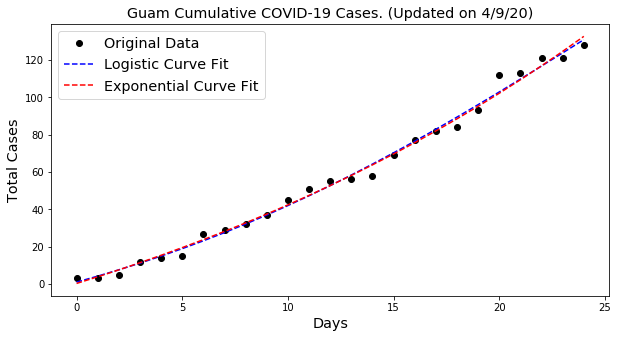



US state:  Grand Princess

** Based on Logistic Fit**

	R^2: 0.9964789119943814
	Doubling Time (during middle of growth):  0.13 (± 2.1 ) days
	param:  [1.84080577e+54 1.10743722e+01 2.47272425e+01 1.03002137e+02]

 exponential R^2  0.752782938015223


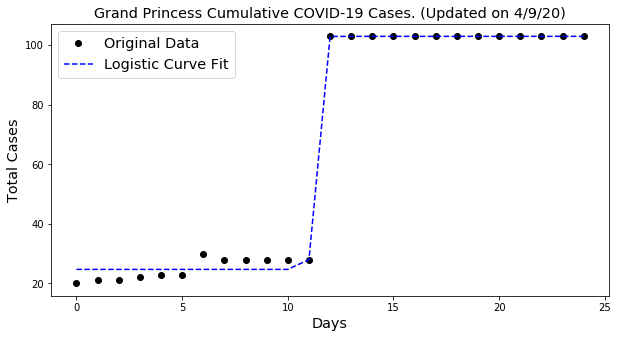

In [5]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


    Recent Doubling Time  Inferred Doubling Time  95%CI
0                    8.7                     7.1    0.5
1                    7.0                     5.6    0.2
2                    7.0                     5.8    0.2
3                    8.0                     6.9    0.2
4                    6.5                     6.1    0.4
5                    5.3                     6.0    0.2
6                    7.0                     4.8    0.6
7                    8.1                     5.4    0.3
8                    7.2                     6.2    0.3
9                    6.1                     7.5    0.5
10                   7.1                     7.5    1.0
11                   5.2                     7.0    1.2
12                  11.8                     8.9    0.3
13      

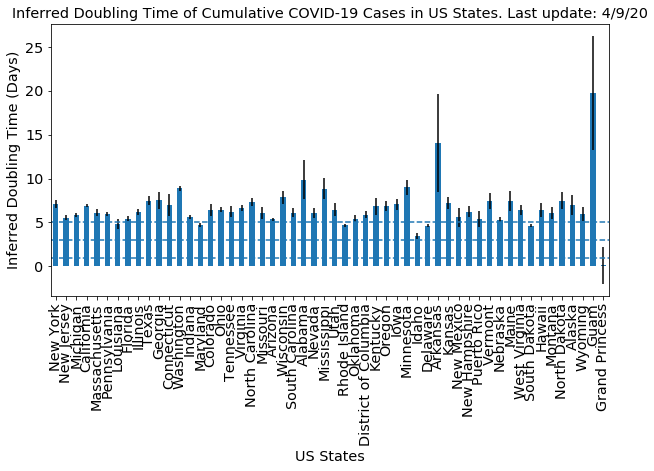

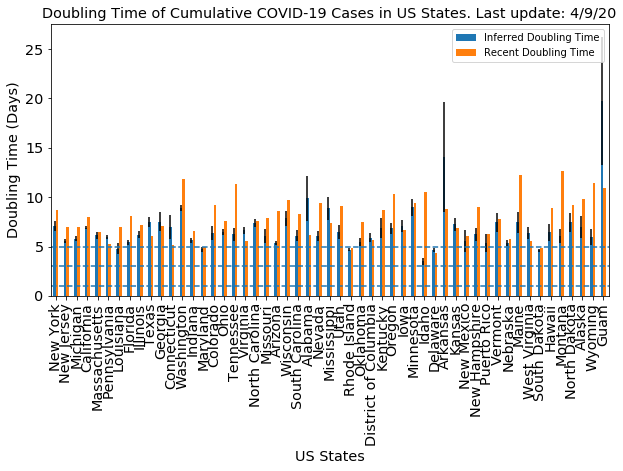

In [6]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).iloc[:,[3,1,2]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=states
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(yerr=err, figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()